In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, LSTM, Dropout,RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


2024-10-16 12:38:26.628265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 12:38:27.473002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 12:38:27.774725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 12:38:27.836768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 12:38:28.296246: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_window = 8

def create_inout_sequences(input_data, tw):
    inout_seq = []
    batches,L,dim = (input_data).shape
    for i in range(batches):
        for j in range(L-tw):
            train_seq = input_data[i,j:j+tw,:]
            train_label = input_data[i,j+tw:j+tw+1,:]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [3]:
# Define the directory where your data files are located
data_directory = '/home/henrique/codigos/tensorflow/pendulum-data/pendulum-lisboa-ist'

# List to store data arrays from each file
data_arrays = []

# Iterate through files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_directory, filename)
        
        # Read the CSV file into a Pandas DataFrame
        df = pd.read_csv(file_path)
        colunas = df.columns
        
        # Assuming that the columns in the CSV files are in the same order as your sample data
        # You may need to adjust the column names if they are different
        #selected_columns = df[['Velocity [m/s]']]
        selected_columns = df[colunas[1:]]
        # Convert the selected columns to a NumPy array
        data_array = selected_columns.to_numpy()
        
        # Append the data array to the list
        data_arrays.append(data_array)


'''scaler1 = MinMaxScaler(feature_range=(-1,0))
scaler2 = MinMaxScaler(feature_range=(0,1))
combined_data = np.concatenate(data_arrays, axis=0)

for i in range(len(combined_data)//64):
    combined_data[64*i:64*i+16] = scaler1.fit_transform(combined_data[64*i:64*i+16])
    combined_data[64*i+16:64*(i+1)] = scaler2.fit_transform(combined_data[64*i+16:64*(i+1)])'''

'scaler1 = MinMaxScaler(feature_range=(-1,0))\nscaler2 = MinMaxScaler(feature_range=(0,1))\ncombined_data = np.concatenate(data_arrays, axis=0)\n\nfor i in range(len(combined_data)//64):\n    combined_data[64*i:64*i+16] = scaler1.fit_transform(combined_data[64*i:64*i+16])\n    combined_data[64*i+16:64*(i+1)] = scaler2.fit_transform(combined_data[64*i+16:64*(i+1)])'

In [38]:

data_arrays_array = (np.array(data_arrays)[:,:,2]).reshape(-1,64,1) # (5643, 64, 4) shape

#Z scale 
'''inputs_mean = np.mean(data_arrays,axis=(0,1))
inputs_std = np.std(data_arrays,axis=(0,1))

print(inputs_mean)
print(inputs_std)

inputs_normalizados = (data_arrays_array-inputs_mean)/inputs_std
'''

#Linear scaling  (x-x_min)/(x_max-m_min) (-1,1)
inputs_min = np.min(data_arrays_array,axis=(0,1))
inputs_max = np.max(data_arrays_array,axis=(0,1))
print(inputs_min)
print(inputs_max)
inputs_normalizados = (data_arrays_array-inputs_min)/(inputs_max-inputs_min)

print(data_arrays_array.shape)

[25.8175259]
[32.9907494]
(5643, 64, 1)


In [56]:
sequencias = create_inout_sequences(data_arrays_array, train_window)


In [57]:
inputs = np.array([seq[0] for seq in sequencias])
outputs = np.array([seq[1] for seq in sequencias]).reshape(-1,1)


In [58]:
print(inputs.shape,outputs.shape)

(316008, 8, 1) (316008, 1)


In [59]:
train_inputs = inputs[:int(0.8*inputs.shape[0]),:,:]
train_outputs = outputs[:int(0.8*outputs.shape[0]),:]

val_inputs = inputs[int(0.8*inputs.shape[0]):int(0.9*inputs.shape[0]),:,:]
val_outputs = outputs[int(0.8*outputs.shape[0]):int(0.9*outputs.shape[0]),:]

test_inputs = inputs[int(0.9*inputs.shape[0]):,:,:]
test_outputs = outputs[int(0.9*outputs.shape[0]):,:]

In [60]:
model = Sequential([
    LSTM(256, input_shape=(train_window, 1),return_sequences=1),
    LSTM(128,return_sequences=0),
    Dense(1)
])
model.summary()

/home/henrique/codigos/tensorflow/tfgpu/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8, 256)         │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.save("world_pendulum_sequencial.keras")

In [78]:
model.compile(optimizer= Adam(learning_rate=1e-6), loss="mse", metrics=["mae"])
earlystopping = EarlyStopping(monitor="val_loss", patience=50)
#model.fit(inputs,outputs, epochs=10, verbose = 2,batch_size = 256*12)
for i in range(2):
    history = model.fit(train_inputs,train_outputs,validation_data=(val_inputs,val_outputs), epochs=100, verbose = 2,batch_size = 256*10,callbacks=earlystopping)
    #model.save("world_pendulum_sequencial.keras")

Epoch 1/100
99/99 - 2s - 20ms/step - loss: 6.3715e-04 - mae: 0.0166 - val_loss: 6.6553e-04 - val_mae: 0.0165
Epoch 2/100
99/99 - 1s - 10ms/step - loss: 6.2835e-04 - mae: 0.0164 - val_loss: 6.6616e-04 - val_mae: 0.0166
Epoch 3/100
99/99 - 1s - 10ms/step - loss: 6.2943e-04 - mae: 0.0164 - val_loss: 6.6486e-04 - val_mae: 0.0165
Epoch 4/100
99/99 - 1s - 10ms/step - loss: 6.2761e-04 - mae: 0.0163 - val_loss: 6.6507e-04 - val_mae: 0.0165
Epoch 5/100
99/99 - 1s - 10ms/step - loss: 6.2762e-04 - mae: 0.0163 - val_loss: 6.6520e-04 - val_mae: 0.0165
Epoch 6/100
99/99 - 1s - 10ms/step - loss: 6.2719e-04 - mae: 0.0163 - val_loss: 6.6774e-04 - val_mae: 0.0166
Epoch 7/100
99/99 - 1s - 10ms/step - loss: 6.3195e-04 - mae: 0.0165 - val_loss: 6.6759e-04 - val_mae: 0.0166
Epoch 8/100
99/99 - 1s - 10ms/step - loss: 6.2847e-04 - mae: 0.0164 - val_loss: 6.6357e-04 - val_mae: 0.0165
Epoch 9/100
99/99 - 1s - 11ms/step - loss: 6.2698e-04 - mae: 0.0163 - val_loss: 6.6354e-04 - val_mae: 0.0165
Epoch 10/100
99/99 

KeyboardInterrupt: 

988/988 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 6.4095e-04 - mae: 0.0171
Test MAE: 0.02


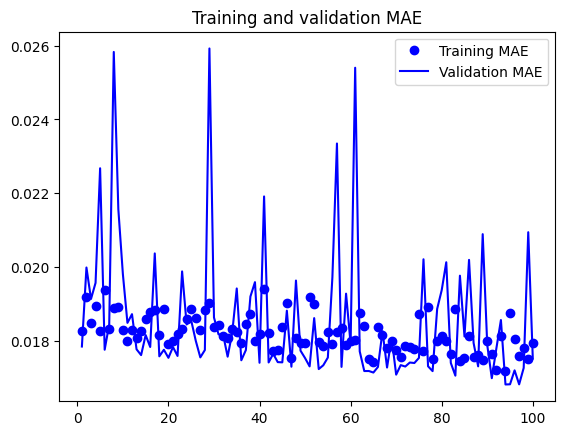

In [75]:
print(f"Test MAE: {model.evaluate(test_inputs,test_outputs)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[[27.3303185], [27.3085079], [27.3067665], [27.3112164], [27.3290749], [27.3436184], [27.3445911], [27.3445663]]


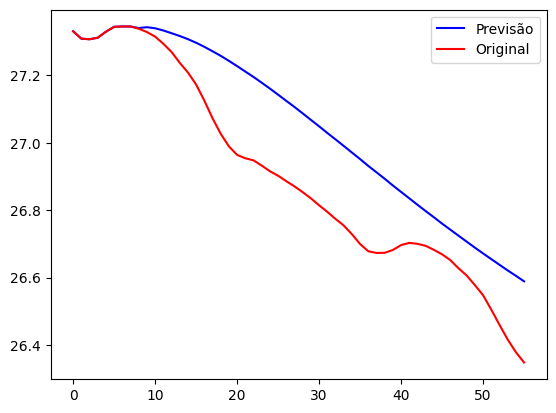

In [81]:
for j in range(1):
    numero = (64-8)*j+24
    sequencia_inicial = test_inputs[numero,:,:].reshape(-1,1)
    lista_total = sequencia_inicial.tolist()
    print(lista_total[0:0+16])
    for i in range(64-16):
        prev_temp = model((np.array([lista_total[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,1)))
        lista_total.append(prev_temp[0])

    previsoes = np.array(lista_total)
    originais = sequencia_inicial.tolist()
    for i in range(64-16):
        originais.append(test_outputs[i+numero,:])
        test_outputs[i+numero]
    originais = np.array(originais)
        
    for i in range(1):
        plt.plot(previsoes[:,i],"b-", label = "Previsão")
        plt.plot(originais[:,i],"r-", label = "Original" )
        plt.legend()
        plt.show()


In [ ]:
print(previsoes)
print(originais)

In [109]:
numero = 64*15+39
sequencia_inicial = test_inputs[numero,:,:].reshape(16)
lista_total = sequencia_inicial.tolist()
for i in range(28):
    sequencia_para_prever= np.array(lista_total[i:i+16]).reshape(1,16,1)
    previsao = model.predict(sequencia_para_prever,verbose=0)
    lista_total.append(previsao[0,0])

velocidades = np.array(lista_total)
velocidades_original = sequencia_inicial.tolist()
for i in range(28):
    velocidades_original.append(test_outputs[i+numero][0,0])
velocidades_original = np.array(velocidades_original)
    

plt.plot(velocidades, label = "Previsão")
plt.plot(velocidades_original,"ro", label = "Original" )
plt.legend()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (44,) + inhomogeneous part.

[[[ 1.        ]
  [ 0.95975351]
  [ 0.89199735]
  [ 0.82174326]
  [ 0.72278701]
  [ 0.61216284]
  [ 0.48997222]
  [ 0.37673185]
  [ 0.25289305]
  [ 0.08214662]
  [-0.08567982]
  [-0.29508031]
  [-0.49539546]
  [-0.66500517]
  [-0.81884626]
  [-1.        ]]]


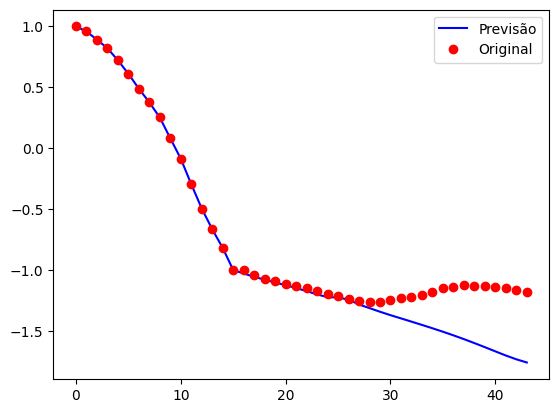

In [131]:
numero = 64*13+34
sequencia_inicial = test_inputs[numero,:,:].reshape(1,16,1)
print(sequencia_inicial)
for i in range(0,28):
    previsao = model.predict(sequencia_inicial[i:].reshape(1,16,1),verbose=0)
    sequencia_inicial = np.append(sequencia_inicial,previsao)

velocidades = np.array(sequencia_inicial)
velocidades_original = sequencia_inicial[:16].tolist()
for i in range(28):
    velocidades_original.append(test_outputs[i+numero][0,0])
velocidades_original = np.array(velocidades_original)
    

plt.plot(velocidades, "b-", label = "Previsão")
plt.plot(velocidades_original,"ro", label = "Original" )
plt.legend()
plt.show()

In [82]:
numero = 64*2+39
sequencia_inicial = test_inputs[numero,:,:].reshape(1,16,1)
print(sequencia_inicial.shape)
velocidades_real = sequencia_inicial.reshape(16).tolist()
print(velocidades_real)
for i in range(28):
    previsao = model.predict(sequencia_inicial[i:].reshape(1,16,1),verbose=0)
    sequencia_inicial = np.append(sequencia_inicial,previsao)
    velocidades_real.append(test_outputs[numero+i][0,0])
    #print(previsao,test_outputs[numero+i])
print(velocidades_real)
velocidades_real = np.array(velocidades_real).reshape(-1)
print(velocidades_real.shape)

(1, 16, 1)
[27.6549168, 27.5943623, 27.5165787, 27.4208031, 27.3466339, 27.3202915, 27.3192978, 27.3040085, 27.2930565, 27.2884903, 27.2780457, 27.2632027, 27.2408028, 27.213726, 27.1855717, 27.159956]
[27.6549168, 27.5943623, 27.5165787, 27.4208031, 27.3466339, 27.3202915, 27.3192978, 27.3040085, 27.2930565, 27.2884903, 27.2780457, 27.2632027, 27.2408028, 27.213726, 27.1855717, 27.159956, 27.1397152, 27.1003265, 27.0959454, 27.1311016, 27.1805973, 27.2164917, 27.2381077, 27.2322502, 27.2210102, 27.2161446, 27.2042046, 27.1829128, 27.1563663, 27.1342907, 27.1186695, 27.1081104, 27.094429, 27.0721855, 27.0382309, 27.0137424, 26.9845181, 26.9297409, 26.8578396, 26.7814445, 26.7013245, 26.6607342, 26.6557388, 26.6477127]
(44,)


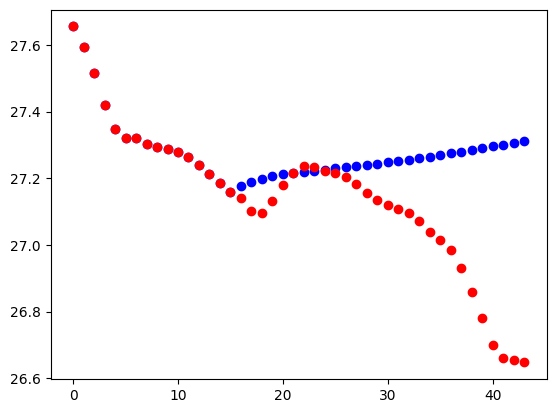

In [83]:
plt.plot(sequencia_inicial,"bo")
plt.plot(velocidades_real,"ro")
plt.show()